# **Shakespeare GPT**
---

from Andrej Karpathy's Tutorial: [ Let's build GPT: from scratch, in code, spelled out. ](https://www.youtube.com/watch?v=kCc8FmEb1nY)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

from tqdm.auto import tqdm

from pathlib import Path

import matplotlib.pyplot as plt

torch.manual_seed(1357)

# Data

In [2]:
with open('/kaggle/input/shakespeare-full-text/shakespeare.txt','r',encoding='utf-8') as f:
    data = f.read()

# Character Level Tokenizer

In [3]:
class CharacterLevelTokenizer:
    def __init__(self,data):
        self.data = data
        self.vocab = sorted(list(set(self.data)))
        self.VOCAB_SIZE = len(self.vocab)
        
        self.i_s = {i:s for i,s in enumerate(self.vocab)}
        self.s_i = {s:i for i,s in self.i_s.items()}
        
    def encode(self,s):
        return torch.tensor([self.s_i[c] for c in s],dtype=torch.long)

    def decode(self,s):
        return ''.join([self.i_s[i.item()] for i in s])

tokenizer = CharacterLevelTokenizer(data)

# Config

In [4]:
@dataclass
class Config:
    block_size = 256 # context-length
    batch_size = 64 # mini-batch size
    vocab_size = tokenizer.VOCAB_SIZE
    n_embed = 128
    n_heads = 4
    head_size = n_embed // n_heads # computes to 384/6=64 or 128/4=32
    
    n_layers = 3
    
    train_iters = 10_000
    val_iters = 1000
    lr = 3e-4
    
    attn_dropout = 0.1
    block_dropout = 0.2
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
Config.device

'cuda'

# Dataset

In [5]:
class ShakespeareDataset:
    def __init__(self,Config, is_test=False) -> None:
        self.tokenizer = CharacterLevelTokenizer(data)
        self.is_test = is_test
        self.full_data = self.tokenizer.encode(self.tokenizer.data)
        if self.is_test:
            self.data = self.full_data[int(0.9*len(self.full_data)):]
        else:
            self.data = self.full_data[:int(0.9*len(self.full_data))]
        self.block_size = Config.block_size
        self.batch_size = Config.batch_size

    def __len__(self) -> int:
        return len(self.data)

    def get_block_size(self) -> int:
        return self.block_size

    def get_vocab_size(self) -> int:
        return self.tokenizer.VOCAB_SIZE

    def get(self):
        ix = torch.randint(len(self.data) - self.block_size, (self.batch_size,))
        x = torch.stack([self.data[i:i+self.block_size] for i in ix])
        y = torch.stack([self.data[i+1:i+self.block_size+1] for i in ix])
        return x,y

---

# **GPT Model**

## Single Attention Head

In [6]:
class AttentionHead(nn.Module):
    def __init__(self, Config):
        super().__init__()

        self.block_size = Config.block_size
        self.n_embed = Config.n_embed
        self.head_size = Config.head_size
        
        self.key = nn.Linear(self.n_embed, self.head_size, bias=False)
        self.query = nn.Linear(self.n_embed, self.head_size, bias=False)
        
        self.value = nn.Linear(self.n_embed, self.head_size, bias=False)

        self.register_buffer(
            'tril',
            torch.tril(torch.ones(self.block_size,self.block_size))
        )
        
        self.dropout = nn.Dropout(Config.attn_dropout)

    def forward(self, x):

        B,T,C = x.shape

        k = self.key(x)
        q = self.query(x)

        wei = q@k.transpose(-2,-1) * (C ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T]==0,float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v
        
        return out

## MultiHead Attention

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.n_heads = Config.n_heads
        self.head_size = Config.head_size
        
        self.heads = nn.ModuleList([AttentionHead(Config) for _ in range(self.n_heads)])
        
        self.projection = nn.Linear(Config.n_embed, Config.n_embed)
        
        self.dropout = nn.Dropout(Config.attn_dropout)
    
    def forward(self,x):
        x = torch.cat([h(x) for h in self.heads],dim=-1)
        x = self.projection(x)
        x = self.dropout(x)
        return x

## Feed Forward Layer

In [8]:
class FeedForward(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Config.n_embed,Config.n_embed * 4),
            nn.ReLU(),
            nn.Linear(Config.n_embed * 4, Config.n_embed), # projection
            nn.Dropout(Config.block_dropout)
        )
    def forward(self,x):
        return self.net(x)

# Transformer Block

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, Config):
        super().__init__()
        self.attn = MultiHeadAttention(Config)
        self.ff = FeedForward(Config)
        self.ln1 = nn.LayerNorm(Config.n_embed)
        self.ln2 = nn.LayerNorm(Config.n_embed)

    def forward(self,x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        
        return x

## GPT Model

In [10]:
class ShakespeareGPT(nn.Module):
    def __init__(self,Config):
        super().__init__()
        
        self.n_embed = Config.n_embed
        self.block_size = Config.block_size
        
        self.token_embedding_table = nn.Embedding(Config.vocab_size,self.n_embed)
        self.pos_embedding_table = nn.Embedding(self.block_size, self.n_embed)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock(Config)]*Config.n_layers,
            nn.LayerNorm(self.n_embed)
        )

        self.lm_head = nn.Linear(self.n_embed,Config.vocab_size)
        
    def forward(self,idx):
        
        B,T = idx.shape
        
        token_embs = self.token_embedding_table(idx)
        pos_embs = self.pos_embedding_table(torch.arange(T,device=Config.device))
        
        
        x = token_embs + pos_embs
        x = self.blocks(x)
        logits = self.lm_head(x)
        
        return logits

        
    def generate(self,idx,total):
        for _ in range(total):
            idx_cond = idx[:, -self.block_size:]
            logits= self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
            

# Training

In [11]:
train_ds = ShakespeareDataset(Config)
val_ds = ShakespeareDataset(Config,is_test=True)

In [12]:
lm = ShakespeareGPT(Config)
lm = lm.to(device=Config.device)

In [13]:
optim = torch.optim.AdamW(lm.parameters(), lr=Config.lr)

In [14]:
def loss_fn(logits, targets):
    B,T,C = logits.shape
    logits = logits.view(B*T, C)
    targets = targets.view(B*T)
    loss = F.cross_entropy(logits,targets)
    return loss

In [15]:
def train_N_iters():
    lm.train()
    train_step_losses = []
    for batch in tqdm(range(Config.train_iters)):
        optim.zero_grad()
        inputs, targets = train_ds.get()
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        loss.backward()
        optim.step()
        train_step_losses.append(loss.item())
        
        if batch%(Config.train_iters//10)==0 or batch==Config.train_iters-1:
            print(f"batch {batch} train step loss: {loss.item()}")
        
        del inputs, targets, loss, logits
        
    return train_step_losses
    
@torch.no_grad()
def valid_N_iters():
    lm.eval()
    val_step_losses = []
    for batch in tqdm(range(Config.val_iters)):
        inputs, targets = val_ds.get()
        inputs, targets = inputs.to(device=Config.device), targets.to(device=Config.device)
        logits = lm(inputs)
        loss = loss_fn(logits,targets)
        val_step_losses.append(loss.item())
        
        if batch%(Config.val_iters//10)==0 or batch==Config.val_iters-1:
            print(f"batch {batch} valid step loss: {loss.item()}")
        
        del inputs, targets, loss, logits
    
    return val_step_losses

In [16]:
def save_lm():
    state_dict = lm.state_dict()
    save_path = Path('./').resolve() / 'shakespeareGPT'
    save_path.mkdir(exist_ok=True)
    model_path = save_path / f'shakespeareGPT.pth'
    torch.save(state_dict, model_path)

In [17]:
def train_lm():
    train_losses = train_N_iters()
    valid_losses = valid_N_iters()
    save_lm()
    return train_losses, valid_losses

In [18]:
tl,vl=train_lm()

  0%|          | 0/10000 [00:00<?, ?it/s]

batch 0 train step loss: 4.303605556488037
batch 1000 train step loss: 2.454551935195923
batch 2000 train step loss: 2.437880277633667
batch 3000 train step loss: 2.315814256668091
batch 4000 train step loss: 2.0116066932678223
batch 5000 train step loss: 1.8777037858963013
batch 6000 train step loss: 1.8346610069274902
batch 7000 train step loss: 1.7588508129119873
batch 8000 train step loss: 1.7117947340011597
batch 9000 train step loss: 1.7134160995483398
batch 9999 train step loss: 1.6846973896026611


  0%|          | 0/1000 [00:00<?, ?it/s]

batch 0 valid step loss: 1.7925341129302979
batch 100 valid step loss: 1.7870755195617676
batch 200 valid step loss: 1.8259053230285645
batch 300 valid step loss: 1.7898788452148438
batch 400 valid step loss: 1.7743006944656372
batch 500 valid step loss: 1.7524681091308594
batch 600 valid step loss: 1.8146271705627441
batch 700 valid step loss: 1.8328163623809814
batch 800 valid step loss: 1.769633412361145
batch 900 valid step loss: 1.7880773544311523
batch 999 valid step loss: 1.7822539806365967


# Loss Plots

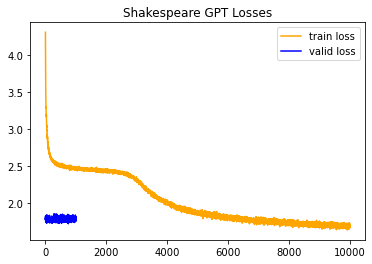

In [19]:
plt.plot(tl,label='train loss',color='orange')
plt.plot(vl,label='valid loss',color='blue')
plt.title('Shakespeare GPT Losses')
plt.legend()
plt.show()

# Generating

In [20]:
generated_texts = []
for length in [100,300,500,700,1000]:
    generated = lm.generate(
    torch.zeros((1,1),dtype=torch.long,device=Config.device), # initial context 0
    total=length
)
    generated = tokenizer.decode(generated[0])
    text=f'generated ({length} tokens)\n{"="*50}\n{generated}\n{"="*50}\n\n'
    generated_texts.append(text)
    print(text)

generated (100 tokens)

HERS OF YORK:
Iffer these peak than all for the be me;
That thou, follived of frome, my does,
I day;


generated (300 tokens)

LADY ANTIO:
Now may hight. The is graclike a heavent;
Ye'lr, or borse to your vales stend
Hence meen shallessile to see ton them oth to:
Goods!
State, what shure gue and nay ild But or this it,
Which cafter, more enhere making werefy loved bein;
And in by the peop, by any home whyserving fried as Du


generated (500 tokens)

Havilse, my statings unto a havisbale of him it my seechies:
Lords come, the must that calls body Greputing me;
Twit son and dayped
I cloody, but and not is
And he dime my fire of us good brimsence to-phe dust.

VOLEONTES:
O, he here, out of; Camine thee!
Become, I'll place, if that the kindly;
The morrown hold you time fathere pass and forwords for in duke
And I hadly me;--
Whose well. I shall no lord shangelown my breation.

Lood
Say, that?

DUKE VINCENTIO:
Yet should kind prost, you speak
To 


generated (700 toke

In [21]:
with open('generated.txt','w') as f:
    for text in generated_texts:
        f.write(text)

---

Full code: [shakespeareGPT](https://github.com/shreydan/shakespeareGPT)

Follow [@shreydan](https://kaggle.com/shreydan) for more :)